Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import pickle
import librosa
import tensorflow as tf
import keras
import copy
import time
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

# Problem 1

Data Preprocessing

In [ ]:
trs_path = '/content/drive/MyDrive/Academics/Fall 2020/Deep Learning/HW4/hw4_trs.pkl'

In [ ]:
L = 45

In [ ]:
with open(trs_path, 'rb') as f:
  data = pickle.load(f)

In [ ]:
def equal_length(waveform, MAX_LENGTH=22631):
  zero_padding = np.zeros(MAX_LENGTH - np.shape(waveform)[0], dtype=np.float32)
  waveform = np.asarray(waveform, np.float32)
  equal_length = np.concatenate((waveform, zero_padding), 0)
  return equal_length

In [ ]:
def get_paired_data(data, L=45):
  X = []
  Y = []
  for k in range(0, len(data), 10):
    posX = []
    for i in range(k, k+10):
      for j in range(i+1, (int(k/10)+1)*10):
        pos1 = np.abs(librosa.stft(equal_length(data[i]), n_fft=1024, hop_length=512)).T
        pos2 = np.abs(librosa.stft(equal_length(data[j]), n_fft=1024, hop_length=512)).T
        posX.append([pos1, pos2])
    posX = np.array(posX)

    diff_spkr_args = np.random.randint(low=0, high=len(data), size=L)
    for i in range(len(diff_spkr_args)):
      while True:
        if diff_spkr_args[i] >= k and diff_spkr_args[i] < k+10:
          diff_spkr_args[i] = np.random.randint(low=0, high=len(data))
        else:
          break
    same_spkr_args = np.random.randint(low=k, high=k+10, size=L)
    
    negX = []
    for i in range(L):
      neg1 = np.abs(librosa.stft(equal_length(data[same_spkr_args[i]]), n_fft=1024, hop_length=512)).T
      neg2 = np.abs(librosa.stft(equal_length(data[diff_spkr_args[i]]), n_fft=1024, hop_length=512)).T
      negX.append([neg1, neg2])
    negX = np.array(negX)
    
    for i in range(L):
      X.append(posX[i])
      Y.append(1)
    for i in range(L):
      X.append(negX[i])
      Y.append(0)
  return np.array(X), np.array(Y)

In [ ]:
X, Y = get_paired_data(data)

In [ ]:
X.shape, Y.shape

((4500, 2, 45, 513), (4500,))

In [ ]:
tes_path = '/content/drive/MyDrive/Academics/Fall 2020/Deep Learning/HW4/hw4_tes.pkl'
with open(tes_path, 'rb') as f:
  test_data = pickle.load(f)
x_test, y_test = get_paired_data(test_data)

In [ ]:
x_test.shape, y_test.shape

((1800, 2, 45, 513), (1800,))

Training

In [ ]:
def create_base_model():
  inp = keras.layers.Input(shape=(45, 513))
  lstm = keras.layers.LSTM(756, return_sequences=False)(inp)
  out = keras.layers.Dense(513)(lstm)
  model = keras.models.Model(inputs=inp, outputs=out)
  return model

In [ ]:
def siamese_network(base_model):
  inputA = keras.layers.Input(shape=(45, 513))
  inputB = keras.layers.Input(shape=(45, 513))

  enc_A = base_model(inputA)
  enc_B = base_model(inputB)
  similarity = keras.layers.Dot(axes=1)([enc_A, enc_B])
  outputs = keras.layers.Dense(1, activation='sigmoid')(similarity)
  model = keras.models.Model(inputs=[inputA, inputB], outputs=outputs)
  return model

In [ ]:
base_model = create_base_model()
model = siamese_network(base_model)

In [ ]:
model.summary()

Model: "functional_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 45, 513)]    0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 45, 513)]    0                                            
__________________________________________________________________________________________________
functional_37 (Functional)      (None, 513)          4228821     input_29[0][0]                   
                                                                 input_30[0][0]                   
__________________________________________________________________________________________________
dot_9 (Dot)                     (None, 1)            0           functional_37[0][0]  

In [ ]:
pred = model.predict([x_test[:1, 0], x_test[:1, 1]])
pred

array([[0.9974733]], dtype=float32)

In [ ]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.00001), 
              loss = keras.losses.binary_crossentropy, 
              metrics=keras.metrics.Accuracy())
model.fit([X[:, 0], X[:, 1]], Y, epochs=1000, batch_size=50, validation_data=([x_test[:, 0], x_test[:, 1]], y_test))

Epoch 1/1000
90/90 [==============================] - 6s 64ms/step - loss: 0.6882 - accuracy: 0.0000e+00 - val_loss: 4.8248 - val_accuracy: 0.0939
Epoch 2/1000
90/90 [==============================] - 5s 57ms/step - loss: 0.6530 - accuracy: 0.0000e+00 - val_loss: 4.9377 - val_accuracy: 0.1367
Epoch 3/1000
90/90 [==============================] - 5s 57ms/step - loss: 0.6104 - accuracy: 0.0000e+00 - val_loss: 4.7897 - val_accuracy: 0.1528
Epoch 4/1000
90/90 [==============================] - 5s 57ms/step - loss: 0.5773 - accuracy: 0.0000e+00 - val_loss: 4.8269 - val_accuracy: 0.1683
Epoch 5/1000
90/90 [==============================] - 5s 57ms/step - loss: 0.5474 - accuracy: 0.0000e+00 - val_loss: 4.7457 - val_accuracy: 0.1767
Epoch 6/1000
90/90 [==============================] - 5s 57ms/step - loss: 0.5351 - accuracy: 0.0000e+00 - val_loss: 4.5537 - val_accuracy: 0.1644
Epoch 7/1000
90/90 [==============================] - 5s 56ms/step - loss: 0.5209 - accuracy: 0.0000e+00 - val_loss: 4

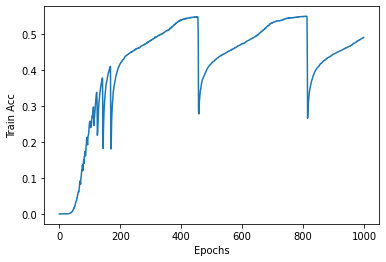

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.ylabel('Train Acc')
plt.xlabel('Epochs')
plt.show()

In [ ]:
model_path = '/content/drive/MyDrive/Academics/Fall 2020/Deep Learning/HW4/P1_Model.h5'
model.save(model_path)

Testing

In [ ]:
model.evaluate([x_test[:, 0], x_test[:, 1]], y_test)

57/57 [==============================] - 1s 15ms/step - loss: 17.0331 - accuracy: 0.4572


[17.033138275146484, 0.45722222328186035]

In [ ]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])
pred = tf.cast(tf.math.greater_equal(pred, 0.5), tf.float32)

In [ ]:
count = 0
for i in range(len(y_test)):
  if y_test[i] == pred[i]:
    count += 1
print("Test Accuracy: " + str(np.round(count*100/len(y_test), 2)) + "%")

Test Accuracy: 65.56%


# Problem 2

In [2]:
tr7_path = '/content/drive/MyDrive/Academics/Fall 2020/Deep Learning/HW4/hw4_tr7.pkl'
te7_path = '/content/drive/MyDrive/Academics/Fall 2020/Deep Learning/HW4/hw4_te7.pkl'

In [3]:
with open(tr7_path, 'rb') as f:
  tr_data = pickle.load(f)

with open(te7_path, 'rb') as f:
  te_data = pickle.load(f)

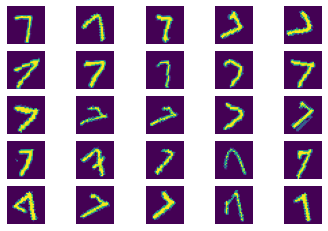

In [54]:
fig, ax = plt.subplots(5, 5)
k = 0
for i in range(5):
  for j in range(5):
    ax[i, j].imshow(tr_data[k].reshape((28, 28)))
    ax[i, j].axis('off')
    k += 1
plt.show()

In [55]:
tr_data = tr_data.reshape(len(tr_data), 28, 28, 1)
te_data = te_data.reshape(len(te_data), 28, 28, 1)

In [58]:
K = 3

In [61]:
def create_encoder():
  encoder_inputs = keras.Input(shape=(28, 28, 1))
  x = keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
  x = keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(16, activation="relu")(x)
  mean = keras.layers.Dense(K)(x)
  log_var = keras.layers.Dense(K)(x)
  encoder = keras.Model(inputs=encoder_inputs, outputs=[mean, log_var])
  return encoder

In [60]:
def create_decoder():
  latent_vec = keras.Input(shape=(K,))
  x = keras.layers.Dense(7 * 7 * 64, activation="relu")(latent_vec)
  x = keras.layers.Reshape((7, 7, 64))(x)
  x = keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  x = keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
  outputs = keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
  decoder = keras.Model(latent_vec, outputs)
  return decoder

In [62]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.K = K

    def train_step(self, data):
        with tf.GradientTape() as tape:
            mu, log_var = self.encoder(data)

            dim1 = tf.shape(mu)[0]
            dim2 = tf.shape(mu)[1]
            epsilon = tf.keras.backend.random_normal(shape=(dim1, dim2))
            sigma = tf.exp(0.5 * log_var)
            latent_vec = mu + tf.exp(0.5 * log_var) * epsilon

            logits = self.decoder(latent_vec)
            logits = tf.reshape(logits,(-1,28,28, 1))


            mean_squared_error = tf.reduce_mean(
                keras.losses.mean_squared_error(data, logits)
            )
            mean_squared_error *= 28 * 28
            latent_loss = 1 + log_var - tf.square(mu) - tf.exp(log_var)
            latent_loss = tf.reduce_mean(latent_loss)
            latent_loss *= -0.5
            total_loss = mean_squared_error + latent_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return { "loss": total_loss, "mse": mean_squared_error, "latent_loss": latent_loss, }

In [63]:
encoder = create_encoder()
decoder = create_decoder()

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
vae.fit(tr_data, epochs=50)

Epoch 1/50
196/196 [==============================] - 1s 4ms/step - loss: 120.0994 - mse: 117.2430 - latent_loss: 2.8564
Epoch 2/50
196/196 [==============================] - 1s 4ms/step - loss: 54.2723 - mse: 52.3462 - latent_loss: 1.9260
Epoch 3/50
196/196 [==============================] - 1s 4ms/step - loss: 50.5097 - mse: 49.2886 - latent_loss: 1.2211
Epoch 4/50
196/196 [==============================] - 1s 4ms/step - loss: 49.1792 - mse: 48.2705 - latent_loss: 0.9087
Epoch 5/50
196/196 [==============================] - 1s 4ms/step - loss: 48.2194 - mse: 47.4730 - latent_loss: 0.7464
Epoch 6/50
196/196 [==============================] - 1s 4ms/step - loss: 47.0627 - mse: 46.3335 - latent_loss: 0.7292
Epoch 7/50
196/196 [==============================] - 1s 5ms/step - loss: 44.6972 - mse: 43.7987 - latent_loss: 0.8985
Epoch 8/50
196/196 [==============================] - 1s 4ms/step - loss: 40.7373 - mse: 39.4497 - latent_loss: 1.2876
Epoch 9/50
196/196 [==========================

In [65]:
def plot_images(pred_images):
  fig, ax = plt.subplots(5, 5)
  for i in range(5):
    for j in range(5):
      ax[i, j].imshow(pred_images[i*j])
      ax[i, j].axis('off')

In [66]:
r = np.random.normal(size = [len(te_data),1]) 
normal = np.random.normal(size=[1,3]) 
normal = np.repeat(normal, len(te_data) ,axis =0)
random_dist_d1 = np.concatenate((r[:,:1],normal[:, 1:]),axis = 1)
random_dist_d2  = np.concatenate((normal[:,:1],r[:,:1],normal[:,1:2]),axis = 1)
random_dist_d3  = np.concatenate((normal[: , 0:2],r[:,:1]),axis = 1)
rand_pred_d1 = np.array(decoder.predict(random_dist_d1)).reshape((len(te_data), 28, 28))
rand_pred_d2 = np.array(decoder.predict(random_dist_d2)).reshape((len(te_data), 28, 28))
rand_pred_d3 = np.array(decoder.predict(random_dist_d3)).reshape((len(te_data), 28, 28))

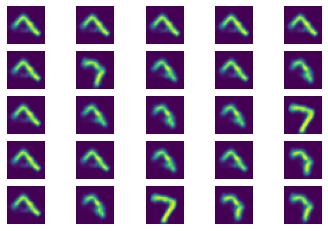

In [68]:
plot_images(rand_pred_d1)

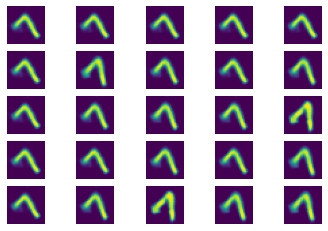

In [69]:
plot_images(rand_pred_d2)

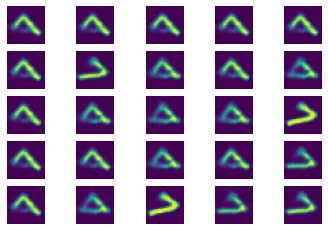

In [70]:
plot_images(rand_pred_d3)

In [71]:
mu, log_var = encoder.predict(te_data)
dim1 = tf.shape(mu)[0]
dim2 = tf.shape(mu)[1]
epsilon = tf.keras.backend.random_normal(shape=(dim1, dim2))
sigma = tf.exp(0.5 * log_var)
latent_vec = mu + tf.exp(0.5 * log_var) * epsilon

In [72]:
te_dist_d1 = np.concatenate((latent_vec[:,:1],normal[:, 1:]),axis = 1)
te_dist_d2 = np.concatenate((normal[:,:1],latent_vec[:,:1],normal[:,1:2]),axis = 1)
te_dist_d3 = np.concatenate((normal[: , 0:2],latent_vec[:,:1]),axis = 1)

te_pred_d1 = np.array(decoder.predict(te_dist_d1)).reshape((len(te_data), 28, 28))
te_pred_d2 = np.array(decoder.predict(te_dist_d2)).reshape((len(te_data), 28, 28))
te_pred_d3 = np.array(decoder.predict(te_dist_d3)).reshape((len(te_data), 28, 28))

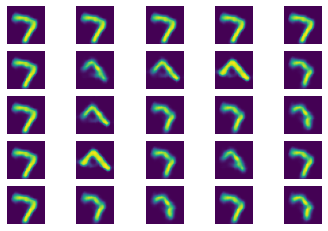

In [73]:
plot_images(te_pred_d1)

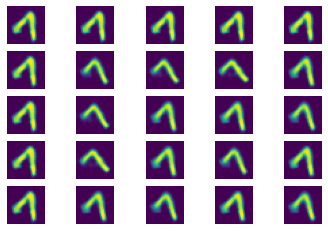

In [74]:
plot_images(te_pred_d2)

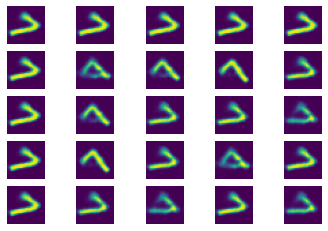

In [75]:
plot_images(te_pred_d3)

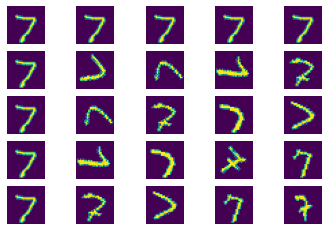

In [76]:
plot_images(te_data.reshape((len(te_data), 28, 28)))

Decoded output relies on the second dimension.

# Problem 3

In [25]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape((len(x_train), 784)) / 255.0
x_test = x_test.reshape((len(x_test), 784))  / 255.0

In [26]:
def create_generator():
  generator = keras.models.Sequential(name='generator')
  generator.add(keras.layers.Dense(110, activation='relu', name='gen_ly1', input_dim=110))
  generator.add(keras.layers.Dense(200, activation='relu', name='gen_ly2'))
  generator.add(keras.layers.Dense(400, activation='relu', name='gen_ly3'))
  generator.add(keras.layers.Dense(784, activation='tanh', name='gen_ly4'))
  return generator

In [27]:
def create_discriminator():
  discriminator = keras.models.Sequential()
  discriminator.add(keras.layers.Dense(400, activation='relu', name='disc_ly1', input_dim=794))
  discriminator.add(keras.layers.Dense(200, activation='relu', name='disc_ly2'))
  discriminator.add(keras.layers.Dense(100, activation='relu', name='disc_ly3'))
  discriminator.add(keras.layers.Dense(1, activation='sigmoid', name='disc_ly4'))
  return discriminator

In [38]:
generator = create_generator()
discriminator = create_discriminator()

optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [39]:

discriminator.trainable = False

inp = keras.Input(shape=(110))
label = keras.Input(shape=(10))

gen_out = generator(inp)

disc_in = tf.concat([gen_out, tf.cast(label, tf.float32)], axis=1)

disc_out = discriminator(disc_in)
combined = keras.Model([inp, label], disc_out)
combined.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])


In [40]:
combined.summary()

Model: "functional_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 110)]        0                                            
__________________________________________________________________________________________________
generator (Sequential)          (None, 784)          429194      input_15[0][0]                   
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_7 (TensorFlo [(None, 794)]        0           generator[0][0]                  
                                                                 input_16[0][0]       

In [41]:
def get_real_disc_in(size):
  ix = np.random.randint(0, len(x_train), size)
  real_imgs = ((x_train[ix]*2) - 1).reshape((size, 784))
  real_labels = []
  for a in y_train[ix]:
    tmp = np.zeros(10)
    tmp[a] = 1
    real_labels.append(tmp)
  real_labels = np.array(real_labels).reshape((size, 10))
  return real_imgs, real_labels

In [42]:
def get_fake_gen_in(size):
  fake_labels = []
  for k in range(10):
    fake_labels.append(np.repeat(k, int(size/10), axis=0))
  fake_labels = np.array(fake_labels).reshape(size)
  fake_labels = LabelBinarizer().fit_transform(fake_labels)
  np.random.shuffle(fake_labels)

  fake_gen_in = []
  for i in range(size):
    random_vec = np.random.normal(0, 1, 100)
    fake_gen_in.append(random_vec)
  fake_gen_in = np.array(fake_gen_in)
  return fake_gen_in, fake_labels

In [43]:
epochs = 50
batch_size = 100

real = np.ones(shape=(int(batch_size/2), 1))
fake = np.zeros(shape=(int(batch_size/2), 1))

d_loss = []
d_g_loss = []
fake_accuracy = []
real_accuracy = []

for e in range(epochs + 1):
    for i in range(len(x_train) // batch_size):
        
        discriminator.trainable = True
        
        real_imgs, real_labels = get_real_disc_in(int(batch_size/2))
        tmp1 = np.concatenate((real_imgs, real_labels), axis=1)
        d_loss_real = discriminator.train_on_batch(x=tmp1, y=real)
        real_pred = np.round(discriminator.predict(tmp1), 1)
        real_acc = np.sum(real_pred)*100/len(tmp1)
        
        
        fake_gen_in, fake_labels = get_fake_gen_in(int(batch_size/2))
        X_fake = generator.predict_on_batch(np.concatenate((fake_gen_in, fake_labels), axis=1))
        tmp2 = np.concatenate((X_fake, fake_labels), axis=1)

        d_loss_fake = discriminator.train_on_batch(x=tmp2, y=fake)
        fake_pred = np.round(discriminator.predict(tmp2), 1)
        fake_acc = (len(tmp2) - np.sum(fake_pred))*100/len(tmp2)

        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        discriminator.trainable = False
        
        fake_gen_in1, fake_labels1 = get_fake_gen_in(int(batch_size/2))
        tmp3 = [np.concatenate((fake_gen_in1, fake_labels1), axis=1), fake_labels1]

        combined_loss_batch = combined.train_on_batch(x=tmp3, y=real)
    
    fake_accuracy.append(fake_acc)
    real_accuracy.append(real_acc)
    d_loss.append(d_loss_batch)
    d_g_loss.append(combined_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f, fake_acc=%.3f, real_acc=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1], fake_acc, real_acc), 100*' ' )

epoch = 1/50, d_loss=0.202, g_loss=3.778, fake_acc=99.600, real_acc=97.600                                                                                                     
epoch = 2/50, d_loss=0.277, g_loss=5.744, fake_acc=100.000, real_acc=99.200                                                                                                     
epoch = 3/50, d_loss=0.023, g_loss=5.099, fake_acc=100.000, real_acc=97.600                                                                                                     
epoch = 4/50, d_loss=0.085, g_loss=5.878, fake_acc=100.000, real_acc=97.800                                                                                                     
epoch = 5/50, d_loss=0.454, g_loss=4.856, fake_acc=99.200, real_acc=99.600                                                                                                     
epoch = 6/50, d_loss=0.068, g_loss=3.787, fake_acc=99.400, real_acc=98.800                                           

KeyboardInterrupt: ignored

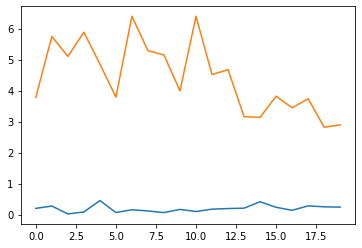

In [45]:
plt.plot(d_loss)
plt.plot(d_g_loss)

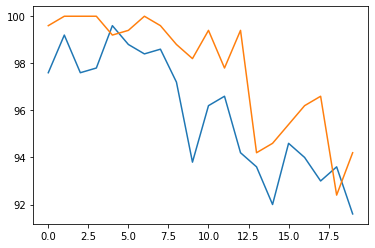

In [46]:
plt.plot(real_accuracy)
plt.plot(fake_accuracy)